In [1]:
# import datetime
import puffin.tardis_importer as ti
symbol = 'BTC'
ti.batch_download(exchange='ftx', symbol_list=[f'{symbol}/USD', f'{symbol}-PERP'], start_date='2021-10-14', end_date = '2021-10-29', data_types =['quotes', 'trades'])


In [8]:
spot_trades = ti.generate_trade_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_trades_2021-10-14_{symbol}-USD.csv.gz')
spot_tobs = ti.generate_tob_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_quotes_2021-10-14_{symbol}-USD.csv.gz')
future_trades = ti.generate_trade_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_trades_2021-10-14_{symbol}-PERP.csv.gz')
future_tobs = ti.generate_tob_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_quotes_2021-10-14_{symbol}-PERP.csv.gz')

<IPython.core.display.Javascript object>


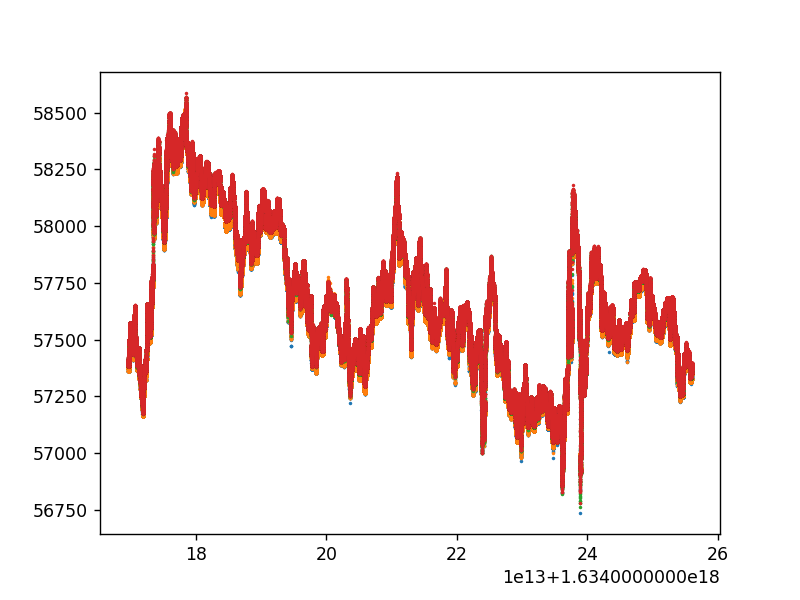

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.scatter(spot_tobs.exchange_timestamp_nanos, spot_tobs.bid_price, s = 1)
plt.scatter(spot_tobs.exchange_timestamp_nanos, spot_tobs.ask_price, s = 1)
plt.scatter(future_tobs.exchange_timestamp_nanos, future_tobs.bid_price, s = 1)
plt.scatter(future_tobs.exchange_timestamp_nanos, future_tobs.ask_price, s = 1)

In [15]:
spot_tobs.describe()

,instrument_id,receive_timestamp_nanos,exchange_timestamp_nanos,bid_price,bid_qty,ask_price,ask_qty
count,627156.0,6.271560e+05,6.271560e+05,627156.000000,627156.000000,627156.000000,627156.000000
mean,30591.0,1.634212e+18,1.634212e+18,57654.522117,1.321988,57656.212520,1.320744
std,0.0,2.458609e+13,2.458609e+13,324.758826,2.206514,324.795404,1.926201
min,30591.0,1.634170e+18,1.634170e+18,56735.000000,0.000100,56842.000000,0.000100
25%,30591.0,1.634191e+18,1.634191e+18,57437.000000,0.310000,57438.000000,0.310400
50%,30591.0,1.634213e+18,1.634213e+18,57602.000000,0.867400,57604.000000,0.840000
75%,30591.0,1.634232e+18,1.634232e+18,57878.000000,1.633500,57879.000000,1.631000
max,30591.0,1.634256e+18,1.634256e+18,58545.000000,70.770500,58549.000000,50.720600


In [17]:
import puffin.config as con
con.config[con.config.symbol == 'BTC/USD']

,id,symbol,tick_size,step_size,minimum_order_size_base,minimum_order_size_quote,exchange
48,30591,BTC/USD,1.0,0.0001,0.0001,5,ftx


In [18]:
con.config[con.config.symbol == 'BTC-PERP']

,id,symbol,tick_size,step_size,minimum_order_size_base,minimum_order_size_quote,exchange
18,30590,BTC-PERP,1.0,0.0001,0.0001,5,ftx


In [79]:
import random

spot_trades_timestamp = 8
spot_tobs_timestamp = 3
future_trades_timestamp = 3
future_tobs_timestamp = 7

def _spot_trade_event():
    print('spot_trade_event')
def _future_trade_event():
    print('future_trade_event')
def _spot_tob_event():
    print('spot_tob_event')
def _future_tob_event():
    print('future_tob_event')
    
events_list = [{'timestamp': spot_trades_timestamp, 'function': _spot_trade_event},
          {'timestamp': spot_tobs_timestamp, 'function': _spot_tob_event},
          {'timestamp': future_trades_timestamp, 'function': _future_trade_event},
          {'timestamp': future_tobs_timestamp, 'function': _future_tob_event}]    

events_dict = {}
for event in events_list:
    if event['timestamp'] in events_dict.keys():
        events_dict[event['timestamp']].append(event['function'])
    else:
        events_dict[event['timestamp']] = [event['function']]
first_timestamp = min(events_dict)
candidate_event_functions = events_dict[first_timestamp]
chosen_event_function = random.choice(candidate_event_functions)
chosen_event_function()

spot_tob_event


In [85]:
l = []
l.append(1)
if not l:
    print('empty')
else:
    print('something')

something


In [5]:
spot_tobs[['exchange_timestamp_nanos', 'bid_price']]

,exchange_timestamp_nanos,bid_price
0,1634169600185619000,57382
1,1634169600845309000,57382
2,1634169601442434000,57382
3,1634169601527455000,57382
4,1634169601785134000,57382
...,...,...
627151,1634255999273160000,57359
627152,1634255999318837000,57359
627153,1634255999407488000,57359
627154,1634255999697064000,57359


In [7]:
future_tobs[['exchange_timestamp_nanos', 'ask_price']]

,exchange_timestamp_nanos,ask_price
0,1634169600540823000,57404
1,1634169600566339000,57404
2,1634169600590952000,57404
3,1634169601228554000,57404
4,1634169601422808000,57405
...,...,...
1212116,1634255999499565000,57383
1212117,1634255999549462000,57383
1212118,1634255999751084000,57383
1212119,1634255999800352000,57383


In [31]:
import pandas as pd
m = pd.merge(spot_tobs[['exchange_timestamp_nanos', 'bid_price']], future_tobs[['exchange_timestamp_nanos', 'ask_price']], how='outer', left_on='exchange_timestamp_nanos', right_on='exchange_timestamp_nanos')
m = m.sort_values(by=['exchange_timestamp_nanos'])
m = m.fillna(method='ffill')
m = m.dropna(how='any')
m['spread'] = 2e4 * (m['ask_price'] - m['bid_price']) / (m['ask_price'] + m['bid_price'])
m

,exchange_timestamp_nanos,bid_price,ask_price,spread
627156,1634169600540823000,57382.0,57404.0,3.833220
627157,1634169600566339000,57382.0,57404.0,3.833220
627158,1634169600590952000,57382.0,57404.0,3.833220
1,1634169600845309000,57382.0,57404.0,3.833220
627159,1634169601228554000,57382.0,57404.0,3.833220
...,...,...,...,...
627154,1634255999697064000,57359.0,57383.0,4.183298
1839259,1634255999751084000,57359.0,57383.0,4.183298
1839260,1634255999800352000,57359.0,57383.0,4.183298
627155,1634255999820993000,57359.0,57383.0,4.183298


In [32]:
m['spread'].mean()

4.992416307813416

<IPython.core.display.Javascript object>


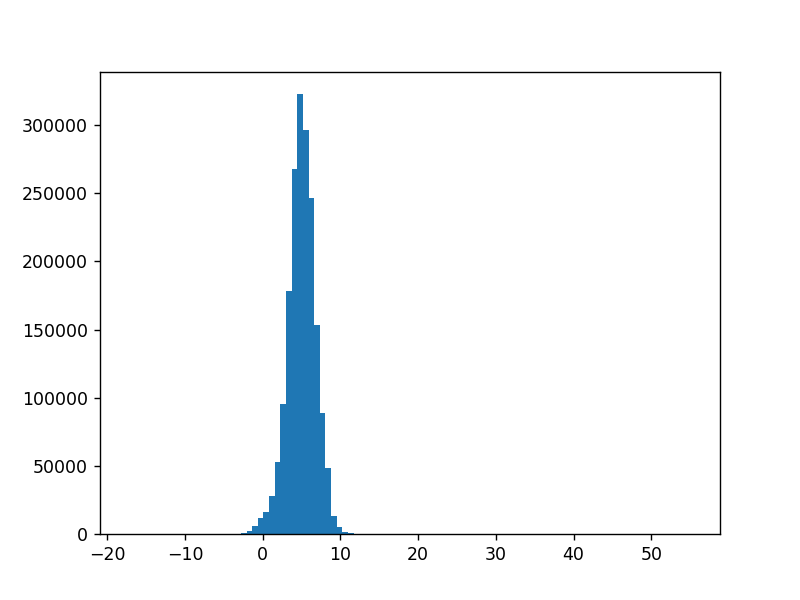

(array([1.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        3.00000e+00, 1.00000e+00, 2.00000e+00, 2.00000e+00, 4.00000e+00,
        0.00000e+00, 6.00000e+00, 1.00000e+01, 5.00000e+00, 8.00000e+00,
        1.40000e+01, 1.90000e+01, 2.90000e+01, 2.01000e+02, 3.25000e+02,
        8.41000e+02, 2.45600e+03, 5.59200e+03, 1.14860e+04, 1.63960e+04,
        2.81380e+04, 5.30390e+04, 9.55640e+04, 1.78496e+05, 2.68054e+05,
        3.22757e+05, 2.96360e+05, 2.46276e+05, 1.53648e+05, 8.91190e+04,
        4.86690e+04, 1.29700e+04, 5.35600e+03, 1.60100e+03, 8.14000e+02,
        2.89000e+02, 1.83000e+02, 1.18000e+02, 7.70000e+01, 7.10000e+01,
        4.90000e+01, 2.90000e+01, 2.70000e+01, 1.60000e+01, 2.50000e+01,
        2.00000e+01, 8.00000e+00, 9.00000e+00, 1.40000e+01, 6.00000e+00,
        4.00000e+00, 1.20000e+01, 6.00000e+00, 6.00000e+00, 2.00000e+00,
        4.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 3.00000e+00, 1.00000e+00, 2.00

In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.hist(m['spread'], bins=100)

In [37]:
import numpy as np
np.quantile(m['spread'], .75)

6.21772396759875

In [4]:
import numpy as np
import pandas as pd
symbol = 'BTC'
for day in range(14, 29):
    spot_tobs = ti.generate_tob_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_quotes_2021-10-{day}_{symbol}-USD.csv.gz')
    future_tobs = ti.generate_tob_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_quotes_2021-10-{day}_{symbol}-PERP.csv.gz')
    m = pd.merge(spot_tobs[['exchange_timestamp_nanos', 'bid_price']], future_tobs[['exchange_timestamp_nanos', 'ask_price']], how='outer', left_on='exchange_timestamp_nanos', right_on='exchange_timestamp_nanos')
    m = m.sort_values(by=['exchange_timestamp_nanos'])
    m = m.fillna(method='ffill')
    m = m.dropna(how='any')
    m['spread'] = 2e4 * (m['ask_price'] - m['bid_price']) / (m['ask_price'] + m['bid_price'])
    print(np.quantile(m['spread'], .75))


6.21772396759875
7.583992719366989
5.978590183801252
8.2418488115254
7.726606892777232
5.093513728611222
9.93168206578987
8.84829907250865
7.692370641330943
5.3606673218593395
3.92631613388738
5.341628568286437
6.034236351510147
3.741560230616167
3.9525040760198284


In [29]:
day = 20
spot_tobs = ti.generate_tob_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_quotes_2021-10-{day}_{symbol}-USD.csv.gz')
future_tobs = ti.generate_tob_data_from_gzip(f'{symbol}/USD', f'./datasets/ftx_quotes_2021-10-{day}_{symbol}-PERP.csv.gz')
m = pd.merge(spot_tobs[['exchange_timestamp_nanos', 'bid_price']], future_tobs[['exchange_timestamp_nanos', 'ask_price']], how='outer', left_on='exchange_timestamp_nanos', right_on='exchange_timestamp_nanos')
m = m.sort_values(by=['exchange_timestamp_nanos'])
m = m.fillna(method='ffill')
m = m.dropna(how='any')
m['spread'] = 2e4 * (m['ask_price'] - m['bid_price']) / (m['ask_price'] + m['bid_price'])
print(np.quantile(m['spread'], .75))

9.93168206578987


In [18]:
 m.loc[::100]['spread']

627156     3.833220
627216     3.136380
627290     3.310595
101        4.355515
128        3.136818
             ...   
626994     5.751784
1839039    6.100271
627045     5.229032
627088     4.706005
1839225    4.183298
Name: spread, Length: 18393, dtype: float64

<IPython.core.display.Javascript object>


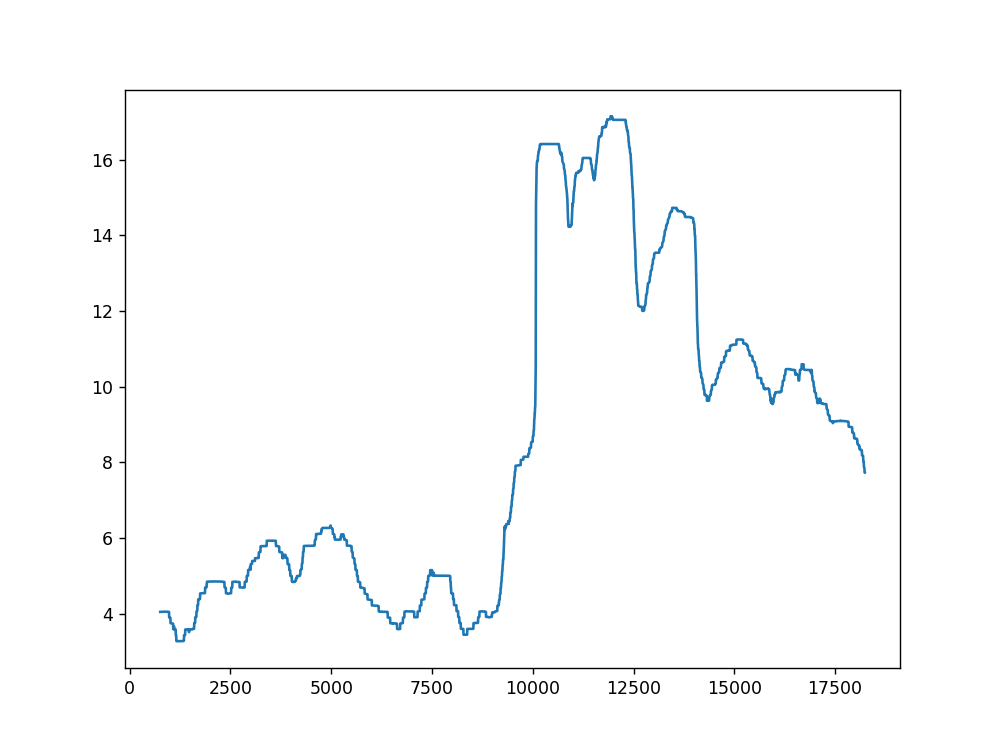

In [28]:
d = m.loc[::100]['spread']
dd = d.rolling(len(d)//24).apply(lambda x: np.quantile(x, .75))
%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(np.array(dd))

In [35]:
len(spot_tobs)//(24*60*60)

6

In [34]:
len(future_tobs)//(24*60*60)

14